# Home Score Card Model

Home Credit Indonesia strives to make predictions through alternative data using various statistical methods and Machine Learning. The prediction model is expected to be able to determine which customers who are able to repay are not rejected when applying for a loan, and loans can be given with a principal, maturity, and repayment calendar that will motivate customers to succeed.

**Objective**
1. Identify customers who have difficulty in repaying loans.
2. Predict customers who have the capacity to repay their loans.

**Goals**
1. Perform data cleaning, data visualization and build prediction models with machine learning.
2. Predict customer repayment ability with the best machine learning model.
3. Provide recommendations to the company to increase customer success in the next loan application.

# Import Library

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [51]:
def minimize_mem(df):
    
    initial_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe: {:.2f} MB'.format(initial_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    final_mem = df.memory_usage().sum() / 1024**2
    
    print('After optimization: {:.2f} MB'.format(final_mem))
    
    return df

def import_df(file):
    df = pd.read_csv(file)
    df = minimize_mem(df)
    return df

In [52]:
data_train = import_df('C:\\Users\\Administrator\\Documents\\Rakamin\\final_train.csv')
data_train.head()

Memory usage of dataframe: 434.03 MB
After optimization: 109.39 MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_POS_NAME_CONTRACT_STATUS,PREV_POS_SK_DPD,PREV_POS_SK_DPD_DEF,PREV_INST_SK_ID_CURR,PREV_INST_NUM_INSTALMENT_VERSION,PREV_INST_NUM_INSTALMENT_NUMBER,PREV_INST_DAYS_INSTALMENT,PREV_INST_DAYS_ENTRY_PAYMENT,PREV_INST_AMT_INSTALMENT,PREV_INST_AMT_PAYMENT
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.000000,0.0,0.0,100002.0,1.052734,10.000000,-295.00,-315.5,11559.247070,11559.247070
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.333252,0.0,0.0,100003.0,1.047852,4.667969,-1164.00,-1172.0,78558.484375,78558.484375
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,1.000000,0.0,0.0,100004.0,1.333008,2.000000,-754.00,-761.5,7096.154785,7096.154785
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.861328,0.0,0.0,100006.0,1.400391,3.166016,-260.75,-286.0,241944.234375,241944.234375
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.275146,0.0,0.0,100007.0,1.129883,6.843750,-1088.00,-1091.0,12122.995117,11671.539062


In [53]:
data_train.shape

(307511, 185)

# Feature Selection

In [54]:
for col in data_train.columns[data_train.lt(0).any()]:
    data_train[col] = data_train[col].abs()

In [55]:
x = data_train.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)
y = data_train['TARGET']

In [56]:
print(x.shape)
print(y.shape)

(307511, 183)
(307511,)


In [57]:
data_train.size

56889535

In [58]:
selection = SelectKBest(score_func=chi2, k=10)
fitting = selection.fit(x,y)
scores = pd.DataFrame(fitting.scores_)
columndf = pd.DataFrame(x.columns)
scoring_feature = pd.concat([columndf, scores], axis = 1)
scoring_feature.columns = ['Features', 'Score']
scoring_feature.sort_values(by=['Score'], ascending=False).head(30)

,Features,Score
129,BURE_AMT_CREDIT_SUM,2.500367e+08
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
165,PREV_DAYS_LAST_DUE_1ST_VERSION,3.773946e+07
166,PREV_DAYS_LAST_DUE,3.765372e+07
167,PREV_DAYS_TERMINATION,2.868925e+07
138,PREV_AMT_APPLICATION,1.809400e+07
127,BURE_AMT_CREDIT_MAX_OVERDUE,1.680393e+07
141,PREV_AMT_GOODS_PRICE,1.100917e+07


Feature selection using Select Kbest method on train data. Features used in the model are only 30 based on the order of the highest score. 

# Balancing Data

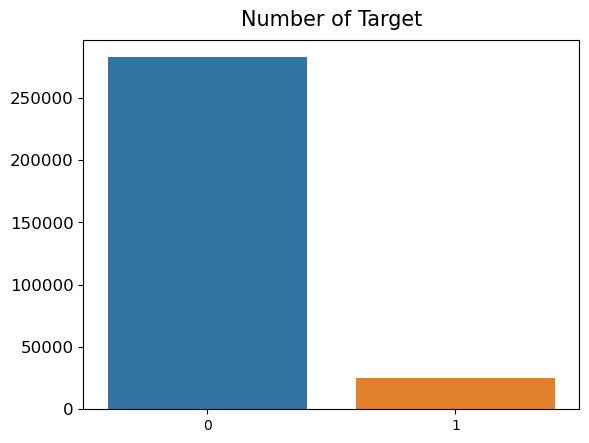

In [59]:
sns.countplot(x='TARGET', data=data_train)
plt.title("Number of Target", loc="center", fontsize=15, pad=10)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=12)
plt.show()

In [60]:
y.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

## Oversampling

In [61]:
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(x,y)

In [62]:
print(x_ros.shape)
print(y_ros.shape)

(565372, 183)
(565372,)


In [63]:
y_ros.value_counts()

TARGET
1    282686
0    282686
Name: count, dtype: int64

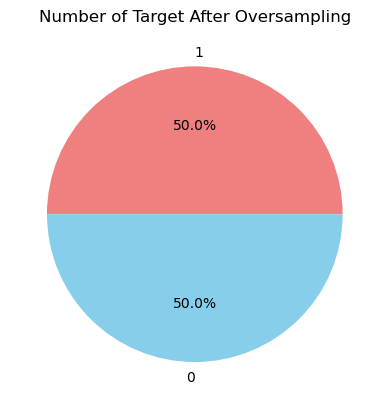

In [64]:
y_ros.value_counts().plot.pie(autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
plt.title('Number of Target After Oversampling')
plt.ylabel(None)
plt.show()

## Undersampling

In [65]:
rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(x,y)

In [66]:
print(x_rus.shape)
print(y_rus.shape)

(49650, 183)
(49650,)


In [67]:
y_rus.value_counts()

TARGET
0    24825
1    24825
Name: count, dtype: int64

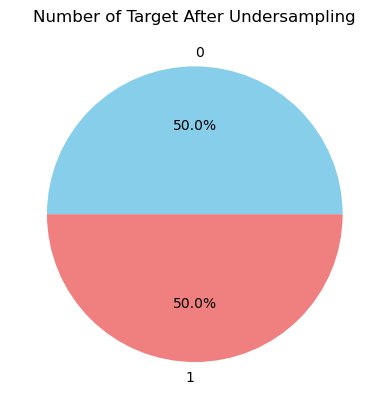

In [68]:
y_rus.value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Number of Target After Undersampling')
plt.ylabel(None)
plt.show()

# Split Data

In [69]:
scoring_feature.sort_values(by='Score', ascending=False).Features.head(30).to_list()

['BURE_AMT_CREDIT_SUM',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'PREV_DAYS_LAST_DUE_1ST_VERSION',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'PREV_AMT_APPLICATION',
 'BURE_AMT_CREDIT_MAX_OVERDUE',
 'PREV_AMT_GOODS_PRICE',
 'PREV_AMT_CREDIT',
 'PREV_AMT_DOWN_PAYMENT',
 'BURE_AMT_CREDIT_SUM_OVERDUE',
 'BURE_AMT_CREDIT_SUM_LIMIT',
 'PREV_DAYS_FIRST_DRAWING',
 'BURE_AMT_CREDIT_SUM_DEBT',
 'PREV_INST_AMT_PAYMENT',
 'PREV_DAYS_FIRST_DUE',
 'DAYS_BIRTH',
 'PREV_AMT_ANNUITY',
 'PREV_INST_AMT_INSTALMENT',
 'BURE_SK_ID_BUREAU',
 'AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION',
 'BURE_DAYS_CREDIT_ENDDATE',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'BURE_DAYS_CREDIT',
 'PREV_SELLERPLACE_AREA',
 'BURE_DAYS_CREDIT_UPDATE']

**Oversampling**

In [70]:
x_ros = x_ros[scoring_feature.sort_values(by='Score', ascending=False).Features.head(30).to_list()]

In [71]:
# splitting tha data
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(x_ros, y_ros, test_size=0.2, random_state=42)

In [72]:
print(X_train_ros.shape, X_test_ros.shape)
print(y_train_ros.shape, y_test_ros.shape)

(452297, 30) (113075, 30)
(452297,) (113075,)


**Undersampling**

In [73]:
x_rus = x_rus[scoring_feature.sort_values(by='Score', ascending=False).Features.head(30).to_list()]

In [74]:
# splitting tha data
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(x_rus, y_rus, test_size=0.2, random_state=42)

In [75]:
print(X_train_rus.shape, X_test_rus.shape)
print(y_train_rus.shape, y_test_rus.shape)

(39720, 30) (9930, 30)
(39720,) (9930,)


# Scaling Data

**Oversampling**

In [76]:
scaler = StandardScaler()
X_train_ros = scaler.fit_transform(X_train_ros)
X_test_ros = scaler.transform(X_test_ros)

**Undersampling**

In [77]:
X_train_rus = scaler.fit_transform(X_train_rus)
X_test_rus = scaler.transform(X_test_rus)

# Build & Evaluation Model

Here are some machine learning algorithms implemented to determine the best prediction model:
1. Logistic Regresion
2. LightGBM
3. Decision Tree

In [78]:
model_eval = pd.DataFrame(columns=['Train_Accuracy','Test_Accuracy','ROC_Score'])

## 1. Logistic Regresion

In [79]:
log = LogisticRegression()

**Oversampling**

In [80]:
log.fit(X_train_ros, y_train_ros)
joblib.dump(log, 'log_model.pkl')

['log_model.pkl']

In [81]:
y_pred = log.predict(X_test_ros)
y_predtr = log.predict(X_train_ros)

print(classification_report(y_test_ros, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.61     56536
           1       0.62      0.64      0.63     56539

    accuracy                           0.62    113075
   macro avg       0.62      0.62      0.62    113075
weighted avg       0.62      0.62      0.62    113075



In [82]:
roc_auc_log = round(roc_auc_score(y_test_ros, y_pred),6)
print('ROC AUC Score:', roc_auc_log)

ROC AUC Score: 0.620455


Text(50.722222222222214, 0.5, 'True Label')

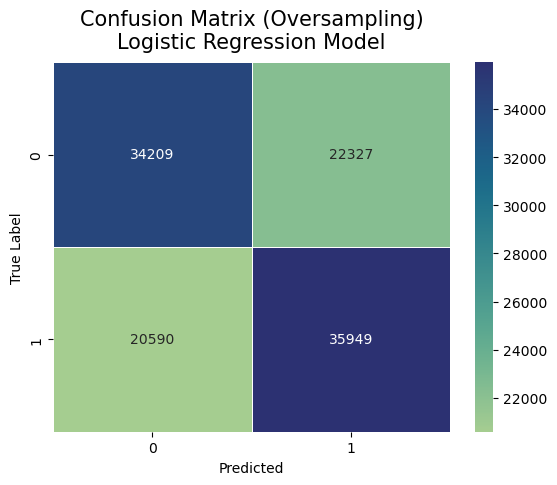

In [83]:
sns.heatmap(confusion_matrix(y_test_ros, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Oversampling)\nLogistic Regression Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [84]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_ros, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_ros, y_pred)*100,2)
roc_score = round(roc_auc_log*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Log_Reg_oversampling'] = [accuracy_tr, accuracy, roc_score]

**Undersampling**

In [85]:
log.fit(X_train_rus, y_train_rus)
joblib.dump(log, 'log_model_rus.pkl')

['log_model_rus.pkl']

In [86]:
y_pred = log.predict(X_test_rus)
y_predtr = log.predict(X_train_rus)

print(classification_report(y_test_rus, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60      4953
           1       0.61      0.63      0.62      4977

    accuracy                           0.61      9930
   macro avg       0.61      0.61      0.61      9930
weighted avg       0.61      0.61      0.61      9930



In [87]:
roc_auc_log_rus = round(roc_auc_score(y_test_rus, y_pred),6)
print('ROC AUC score:', roc_auc_log_rus)

ROC AUC score: 0.613342


Text(50.722222222222214, 0.5, 'True Label')

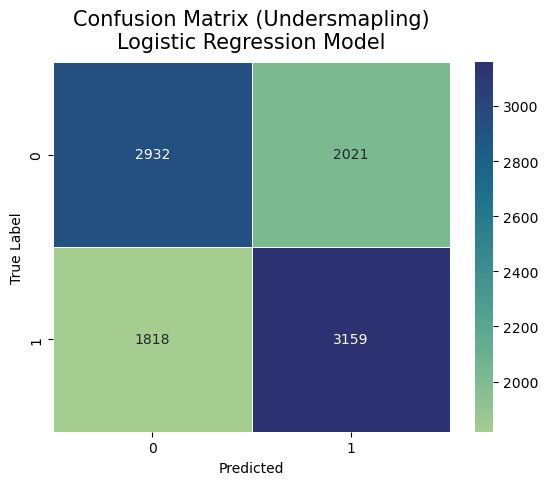

In [88]:
sns.heatmap(confusion_matrix(y_test_rus, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Undersmapling)\nLogistic Regression Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [89]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_rus, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_rus, y_pred)*100,2)
roc_score = round(roc_auc_log_rus*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Log_Reg_undersampling'] = [accuracy_tr, accuracy, roc_score]

## 2. LightGBM

In [90]:
lgbm = LGBMClassifier()

**Upsampling**

In [91]:
lgbm.fit(X_train_ros, y_train_ros)
joblib.dump(lgbm, 'lgbm_model.pkl')

[LightGBM] [Info] Number of positive: 226147, number of negative: 226150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7409
[LightGBM] [Info] Number of data points in the train set: 452297, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499997 -> initscore=-0.000013
[LightGBM] [Info] Start training from score -0.000013


['lgbm_model.pkl']

In [92]:
y_pred = lgbm.predict(X_test_ros)
y_predtr = lgbm.predict(X_train_ros)

print(classification_report(y_test_ros, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     56536
           1       0.68      0.68      0.68     56539

    accuracy                           0.68    113075
   macro avg       0.68      0.68      0.68    113075
weighted avg       0.68      0.68      0.68    113075



In [93]:
roc_auc_lgbm = round(roc_auc_score(y_test_ros, y_pred),6)
print('ROC AUC Score:', roc_auc_lgbm)

ROC AUC Score: 0.67686


Text(50.722222222222214, 0.5, 'True Label')

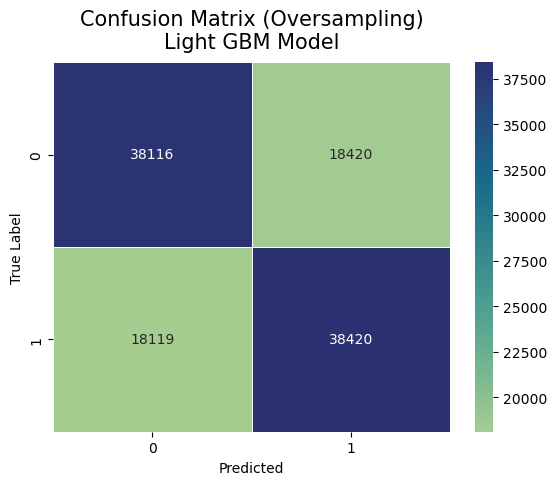

In [94]:
sns.heatmap(confusion_matrix(y_test_ros, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Oversampling)\nLight GBM Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [95]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_ros, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_ros, y_pred)*100,2)
roc_score = round(roc_auc_lgbm*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Light_GBM_oversampling'] = [accuracy_tr, accuracy, roc_score]

**Undersampling**

In [96]:
lgbm.fit(X_train_rus, y_train_rus)
joblib.dump(lgbm, 'lgbm_model_rus.pkl')

[LightGBM] [Info] Number of positive: 19848, number of negative: 19872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7306
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499698 -> initscore=-0.001208
[LightGBM] [Info] Start training from score -0.001208


['lgbm_model_rus.pkl']

In [97]:
y_pred = lgbm.predict(X_test_rus)
y_predtr = lgbm.predict(X_train_rus)

print(classification_report(y_test_rus, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64      4953
           1       0.65      0.64      0.64      4977

    accuracy                           0.64      9930
   macro avg       0.64      0.64      0.64      9930
weighted avg       0.64      0.64      0.64      9930



In [98]:
roc_auc_lgbm_rus = round(roc_auc_score(y_test_rus, y_pred),6)
print('ROC AUC Score:', roc_auc_lgbm_rus)

ROC AUC Score: 0.643813


Text(50.722222222222214, 0.5, 'True Label')

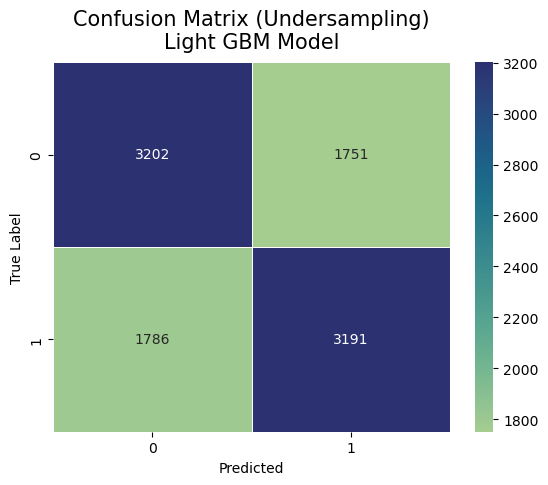

In [99]:
sns.heatmap(confusion_matrix(y_test_rus, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Undersampling)\nLight GBM Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [100]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_rus, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_rus, y_pred)*100,2)
roc_score = round(roc_auc_lgbm_rus*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Light_GBM_undersampling'] = [accuracy_tr, accuracy, roc_score]

## 3. Decision Tree

In [101]:
dt = DecisionTreeClassifier()

**Upsampling**

In [102]:
dt.fit(X_train_ros, y_train_ros)
joblib.dump(dt, 'dt_model.pkl')

['dt_model.pkl']

In [103]:
y_pred = dt.predict(X_test_ros)
y_predtr = dt.predict(X_train_ros)

print(classification_report(y_test_ros, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56536
           1       0.91      1.00      0.95     56539

    accuracy                           0.95    113075
   macro avg       0.95      0.95      0.95    113075
weighted avg       0.95      0.95      0.95    113075



In [104]:
roc_auc_dt = round(roc_auc_score(y_test_ros, y_pred),6)
print('ROC AUC Score:', roc_auc_dt)

ROC AUC Score: 0.950005


Text(50.722222222222214, 0.5, 'True Label')

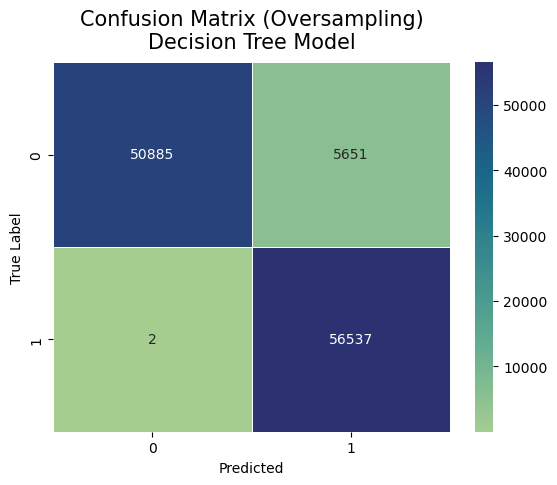

In [106]:
sns.heatmap(confusion_matrix(y_test_ros, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Oversampling)\nDecision Tree Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [107]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_ros, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_ros, y_pred)*100,2)
roc_score = round(roc_auc_dt*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Decision_Tree_oversampling'] = [accuracy_tr, accuracy, roc_score]

**Undersampling**

In [108]:
dt.fit(X_train_rus, y_train_rus)
joblib.dump(dt, 'dt_model_rus.pkl')

['dt_model_rus.pkl']

In [109]:
y_pred = dt.predict(X_test_rus)
y_predtr = dt.predict(X_train_rus)

print(classification_report(y_test_rus, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      4953
           1       0.55      0.55      0.55      4977

    accuracy                           0.55      9930
   macro avg       0.55      0.55      0.55      9930
weighted avg       0.55      0.55      0.55      9930



In [110]:
roc_auc_dt_rus = round(roc_auc_score(y_test_rus, y_pred),6)
print('ROC AUC Score:', roc_auc_dt_rus)

ROC AUC Score: 0.550956


Text(50.722222222222214, 0.5, 'True Label')

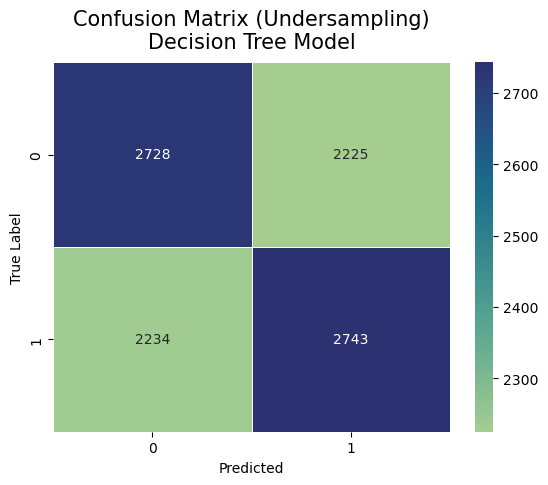

In [111]:
sns.heatmap(confusion_matrix(y_test_rus, y_pred), annot=True, fmt='d', linewidth=.5, cmap= 'crest')
plt.title('Confusion Matrix (Undersampling)\nDecision Tree Model', fontsize=15, pad=10)
plt.xlabel('Predicted')
plt.ylabel('True Label')

In [112]:
#input evaluation result into dataframe
accuracy_tr = round(accuracy_score(y_train_rus, y_predtr)*100,2)
accuracy = round(accuracy_score(y_test_rus, y_pred)*100,2)
roc_score = round(roc_auc_dt_rus*100,2)
#Appen to Dataframe Model Evaluation
model_eval.loc['Decision_Tree_undersampling'] = [accuracy_tr, accuracy, roc_score]

In [113]:
model_eval.sort_values(by=['Train_Accuracy', 'Test_Accuracy'], ascending=False).style.background_gradient(cmap='Greens').format("{:.2f}", subset=model_eval.columns)

,Train_Accuracy,Test_Accuracy,ROC_Score
Decision_Tree_oversampling,100.00,95.00,95.00
Decision_Tree_undersampling,100.00,55.10,55.10
Light_GBM_undersampling,71.68,64.38,64.38
Light_GBM_oversampling,68.69,67.69,67.69
Log_Reg_undersampling,62.28,61.34,61.33
Log_Reg_oversampling,62.20,62.05,62.05


The prediction accuracy of the training data and test data on the Decision Tree model has a value difference that is not too far away, the ROC score is also good. So the Decision Tree model was chosen as a model to predict the ability to repay customers.

# Prediction

## Load Dataset

In [114]:
data_test = import_df('C:\\Users\\Administrator\\Documents\\Rakamin\\final_test.csv')
data_test.head()

Memory usage of dataframe: 71.77 MB
After optimization: 18.13 MB


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_POS_NAME_CONTRACT_STATUS,PREV_POS_SK_DPD,PREV_POS_SK_DPD_DEF,PREV_INST_SK_ID_CURR,PREV_INST_NUM_INSTALMENT_VERSION,PREV_INST_NUM_INSTALMENT_NUMBER,PREV_INST_DAYS_INSTALMENT,PREV_INST_DAYS_ENTRY_PAYMENT,PREV_INST_AMT_INSTALMENT,PREV_INST_AMT_PAYMENT
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0.799805,0.000000,0.0,100001.0,1.250000,2.500000,-1664.0,-1680.0,7312.725098,7312.725098
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,1.000000,0.000000,0.0,100005.0,1.111328,5.000000,-586.0,-609.5,6240.205078,6240.205078
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0.597656,1.619141,0.0,100013.0,1.050781,6.027344,-855.0,-867.5,16349.078125,13702.793945
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0.369141,0.000000,0.0,100028.0,1.039062,17.593750,-945.0,-950.0,7836.897949,7557.738281
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0.307617,0.000000,0.0,100038.0,1.000000,6.500000,-622.0,-634.0,11100.336914,11100.336914


In [115]:
data_test.shape

(48744, 193)

In [116]:
data_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,PREV_POS_NAME_CONTRACT_STATUS,PREV_POS_SK_DPD,PREV_POS_SK_DPD_DEF,PREV_INST_SK_ID_CURR,PREV_INST_NUM_INSTALMENT_VERSION,PREV_INST_NUM_INSTALMENT_NUMBER,PREV_INST_DAYS_INSTALMENT,PREV_INST_DAYS_ENTRY_PAYMENT,PREV_INST_AMT_INSTALMENT,PREV_INST_AMT_PAYMENT
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0.799805,0.000000,0.0,100001.0,1.250000,2.500000,-1664.0,-1680.0,7312.725098,7312.725098
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,1.000000,0.000000,0.0,100005.0,1.111328,5.000000,-586.0,-609.5,6240.205078,6240.205078
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0.597656,1.619141,0.0,100013.0,1.050781,6.027344,-855.0,-867.5,16349.078125,13702.793945
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0.369141,0.000000,0.0,100028.0,1.039062,17.593750,-945.0,-950.0,7836.897949,7557.738281
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0.307617,0.000000,0.0,100038.0,1.000000,6.500000,-622.0,-634.0,11100.336914,11100.336914


## Data Preprocessing

In [117]:
print("\nDuplicated row: ", data_test.duplicated().sum())


Duplicated row:  0


In [118]:
## function for looking precentage of missing values in df
def miss_percent(df):
    result = (df.isnull().sum().sum() / df.size) * 100
    return result

#function for looking precentage of missing values in columns
def in_col(df):
    percent = df.isnull().sum() / len(df)
    result_df = pd.DataFrame({'column_index': percent.index, 'percentage': percent.values})
    result_df = result_df.sort_values(by='percentage', ascending=False)

    return result_df

In [119]:
miss_percent(data_test)

0.0

In [120]:
in_col(data_test)

,column_index,percentage
0,SK_ID_CURR,0.0
97,FLAG_DOCUMENT_4,0.0
123,BURE_CREDIT_CURRENCY,0.0
124,BURE_DAYS_CREDIT,0.0
125,BURE_CREDIT_DAY_OVERDUE,0.0
...,...,...
67,LIVINGAPARTMENTS_MODE,0.0
68,LIVINGAREA_MODE,0.0
69,NONLIVINGAPARTMENTS_MODE,0.0
70,NONLIVINGAREA_MODE,0.0


In [155]:
#convert negatif values to positif values
for col in data_test.columns[data_test.lt(0).any()]:
    data_test[col] = data_test[col].abs()

In [156]:
pred_data = data_test[scoring_feature.sort_values(by='Score', ascending=False).Features.head(30).to_list()]
pred_data.head()

,BURE_AMT_CREDIT_SUM,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_AMT_APPLICATION,BURE_AMT_CREDIT_MAX_OVERDUE,PREV_AMT_GOODS_PRICE,...,PREV_INST_AMT_INSTALMENT,BURE_SK_ID_BUREAU,AMT_INCOME_TOTAL,DAYS_REGISTRATION,BURE_DAYS_CREDIT_ENDDATE,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,BURE_DAYS_CREDIT,PREV_SELLERPLACE_AREA,BURE_DAYS_CREDIT_UPDATE
0,207623.578125,2329,450000.0,568800.0,1499.000000,1619.000000,1612.000000,24835.50,0.0,24835.5,...,7312.725098,5896633.0,135000.0,5168.0,82.4375,1740.0,812,735.000,23.000000,93.12500
1,219042.000000,4469,180000.0,222768.0,376.000000,466.000000,460.000000,22308.75,0.0,44617.5,...,6240.205078,6735201.0,99000.0,9120.0,439.2500,0.0,1623,190.625,18.000000,54.34375
2,518070.000000,4458,630000.0,663264.0,515.666687,715.666687,710.333313,130871.25,19305.0,174495.0,...,16349.078125,5922081.0,202500.0,2176.0,1068.0000,856.0,3503,1738.000,82.000000,775.50000
3,126739.593750,1866,1575000.0,1575000.0,121221.335938,121171.335938,121182.664062,49207.50,0.0,82012.5,...,7836.897949,6356884.5,315000.0,2000.0,2388.0000,1805.0,4208,1402.000,1409.599976,651.50000
4,207954.906250,2191,625500.0,625500.0,457.000000,457.000000,449.000000,267727.50,0.0,267727.5,...,11100.336914,6168714.5,180000.0,4000.0,107.0625,821.0,4262,1063.000,13.000000,467.50000


In [157]:
pred_data.shape

(48744, 30)

In [164]:
model = joblib.load('lgbm_model.pkl')
model_us = joblib.load('lgbm_model_rus.pkl')

**Oversampling**

In [165]:
predict = pd.Series(model.predict(pred_data), name = "TARGET").astype(int)
submission = pd.concat([data_test['SK_ID_CURR'], predict],axis = 1)
submission.head(15)

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
5,100042,0
6,100057,0
7,100065,0
8,100066,0
9,100067,0


In [166]:
submission.TARGET.value_counts()

TARGET
0    48278
1      466
Name: count, dtype: int64

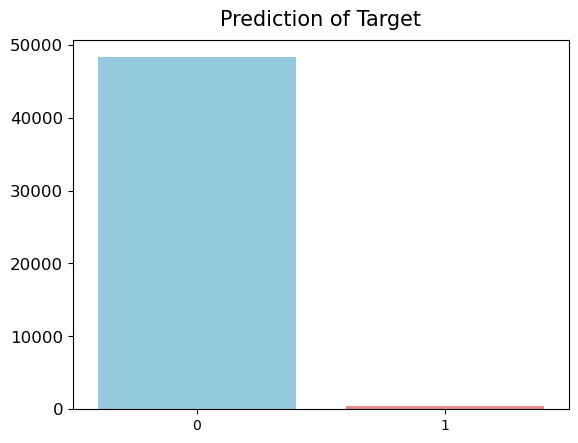

In [167]:
sns.countplot(x='TARGET', data=submission, palette=['skyblue', 'lightcoral'])
plt.title("Prediction of Target", loc="center", fontsize=15, pad=10)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=12)
plt.show()

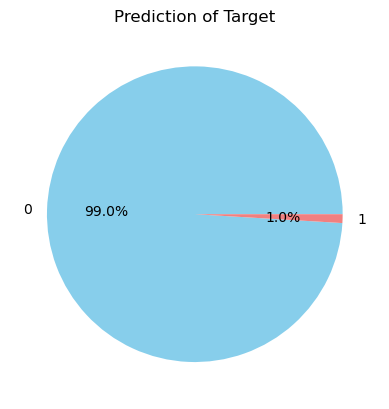

In [168]:
submission.TARGET.value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Prediction of Target')
plt.ylabel(None)
plt.show()

In [173]:
submission.to_excel("submission_lgbm.xlsx", index = False)

**Undersampling**

In [169]:
predict = pd.Series(model_us.predict(pred_data), name = "TARGET").astype(int)
submission_us = pd.concat([data_test['SK_ID_CURR'], predict],axis = 1)
submission_us.head(15)

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,1
3,100028,0
4,100038,0
5,100042,1
6,100057,0
7,100065,0
8,100066,0
9,100067,0


In [170]:
submission_us.TARGET.value_counts()

TARGET
0    41330
1     7414
Name: count, dtype: int64

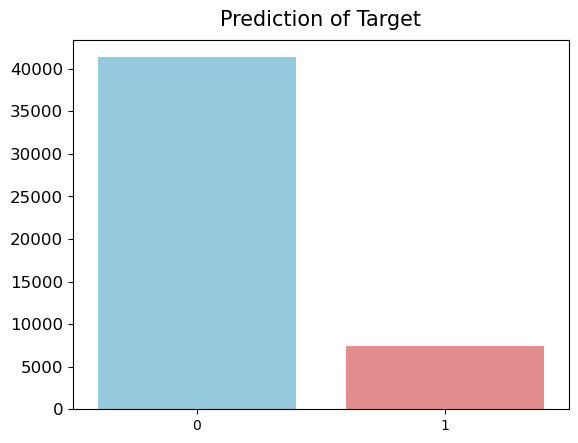

In [171]:
sns.countplot(x='TARGET', data=submission_us, palette=['skyblue', 'lightcoral'])
plt.title("Prediction of Target", loc="center", fontsize=15, pad=10)
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=12)
plt.show()

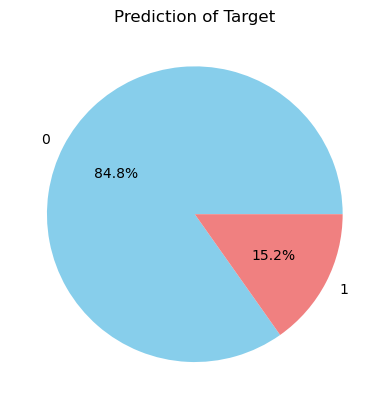

In [172]:
submission_us.TARGET.value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Prediction of Target')
plt.ylabel(None)
plt.show()

In [175]:
submission_us.to_excel("submission_lgbm_us.xlsx", index = False)